In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from random import randrange
import pandas as pd
from IPython.display import clear_output
from termcolor import colored
import os

/home/vipin/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [5]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = train_data['label']

In [7]:
train_data.drop(columns=['label'], inplace=True, axis=1)

In [8]:
x_train = train_data.values.reshape(-1, 28, 28, 1)
x_test = test_data.values.reshape(-1, 28, 28, 1)

In [9]:
del train_data
del test_data

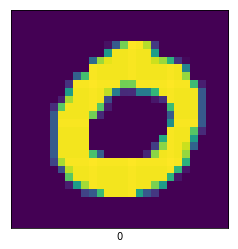

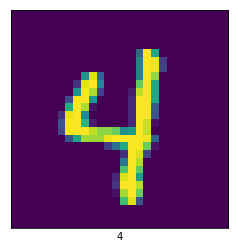

In [10]:
for i in range(2):
    j = randrange(0, 42000)
    plt.imshow(x_train[j][:,:,0])
    plt.xlabel(y_train[j])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

In [11]:
x = tf.placeholder(tf.float32, [None, 28, 28, 1])

y= tf.placeholder(tf.float32, [None, 10])


initializer = tf.contrib.layers.xavier_initializer()

weights = {'w_conv1': tf.Variable(initializer([3, 3, 1, 8])),
           'w_conv2': tf.Variable(initializer([5, 5, 8, 16])),
           'w_conv3': tf.Variable(initializer([3, 3, 16, 16])),
           'w_fc1': tf.Variable(initializer([7*7*16, 128])),
           'out': tf.Variable(initializer([128, 10]))}

biases = {'b_conv1': tf.Variable(tf.random_normal([8])),
          'b_conv2': tf.Variable(tf.random_normal([16])),
          'b_conv3': tf.Variable(tf.random_normal([16])),
          'b_fc1': tf.Variable(tf.random_normal([128])),
          'out': tf.Variable(tf.random_normal([10]))}

In [12]:
def CNN(x):
    
    inputs = tf.cast(x, dtype=tf.float32)
    input_layer = tf.reshape(inputs, [-1, 28, 28, 1])
    
    
    conv1 = tf.nn.relu(tf.add(tf.nn.conv2d(input_layer, weights['w_conv1'], strides=[1, 1, 1, 1], padding='SAME',
                                name='conv1'), biases['b_conv1']))
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
                       
    
    conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(pool1, weights['w_conv2'], strides=[1, 1, 1, 1], padding='SAME',
                                          name='conv2'), biases['b_conv2']))
    
    conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(conv2, weights['w_conv3'], strides=[1, 1, 1, 1], padding='SAME',
                                          name='conv2'), biases['b_conv3']))
    
    pool2 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    dropout = tf.nn.dropout(pool2, keep_prob=0.8)
                       
                       
    flatten = tf.reshape(dropout, [-1, 7*7*16])
                       
                       
    fully_connected = tf.add(tf.matmul(flatten, weights['w_fc1']), biases['b_fc1'])
                       
    dropout = tf.nn.dropout(fully_connected, keep_prob=0.8)
                       
    out = tf.add(tf.matmul(dropout, weights['out']), biases['out'])
                       
    return out
    

In [13]:
def one_hot(i):
    a = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    a[i] = 1
    return a

In [14]:
def get_batch(batch_size, mode):
    # mode 0 for getting training batches
    # mode 1 for getting validation batches
    batch_x = []
    batch_y = []
    for i in range(batch_size):
        if mode == 0:
            j = randrange(0, 40000)
        elif mode == 1:
            j = randrange(40000, 42000)
        batch_x.append(x_train[j])
        batch_y.append(one_hot(y_train[j]))
    return batch_x, batch_y

In [16]:
def train_neural_network(x):
    
    prediction = CNN(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
    y_pred = tf.nn.softmax(prediction)
    
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)
    
    saver = tf.train.Saver()
    
    num_epochs = 5
    best_val = 0

    
    with tf.Session() as sess:
        
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))  # 1 represents the axis
        accuracy = tf.reduce_mean(tf.cast(correct, 'float32'))
        best_val = 0
        
        if os.path.exists('./model.ckpt.index'):
            print('Restoring Model')
            saver.restore(sess, './model.ckpt')
            print('Model Restored')
            val_x, val_y = get_batch(100, 1)
            best_val = accuracy.eval({x: val_x, y: val_y})
            print('Saved model\'s validation accuracy is:', best_val)
            
    
        else:
            sess.run(tf.global_variables_initializer())
        
        
        for epochs in range(num_epochs):
            acc = 0
            epoch_loss = 0
            
            
            for i in range((x_train.shape[0]-2000)//100):
                batch_x, batch_y = get_batch(100, 0)
                feed_dict = {x : batch_x, y: batch_y}
                _ , c = sess.run([optimizer, cost], feed_dict)
                epoch_loss += c
                clear_output(wait=True)
                acc = accuracy.eval(feed_dict=feed_dict)
                print('Epoch:', epochs+1, '|', 'Loss:', colored( "%.4f" % c, 'red'), '|', 'Train Accuracy', 
                      colored("%.4f" % acc, 'green'), '|', i, 'out of', (x_train.shape[0]-2000)//100, 
                      ' iterations done')
            
            
            
            for i in range(2000//100):
                val_x, val_y = get_batch(100, 1)
                acc += accuracy.eval({x: val_x, y: val_y})
            val_acc = acc / (2000//100)
            
            
            if val_acc>best_val:
                save_path = saver.save(sess, './model.ckpt')
                print('Saved model\'s validation accuracy is:', best_val)
                best_val = val_acc
                
            print('Epoch', epochs, 'completed out of', num_epochs, '|', 'Epoch Loss:', colored("%.4f" % epoch_loss, 'red')
                  , '|', 'Validation Accuracy', colored("%.4f" % val_acc, 'green'))


In [17]:
train_neural_network(x)

Epoch: 5 | Loss: 0.1045 | Train Accuracy 0.9700 | 399 out of 400  iterations done
Saved model's validation accuracy is: 0.9975000381469726
Epoch 4 completed out of 5 | Epoch Loss: 50.9473 | Validation Accuracy 1.0075


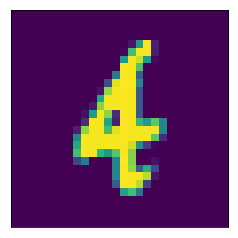

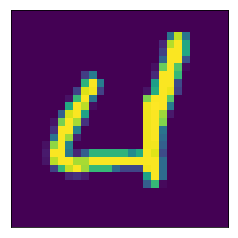

In [18]:
for i in range(2):
    j = randrange(0, x_test.shape[0])
    plt.imshow(x_test[j][:,:,0])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()

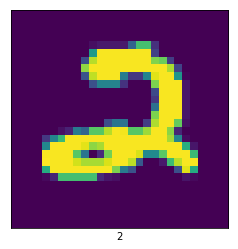

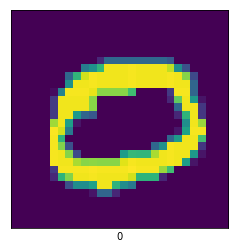

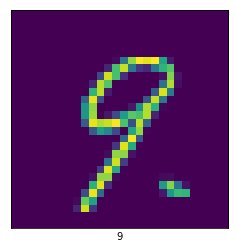

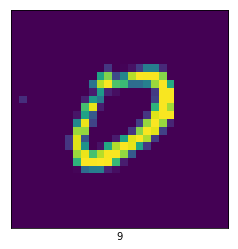

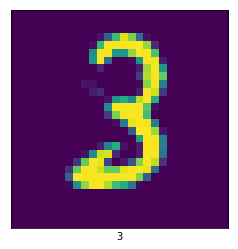

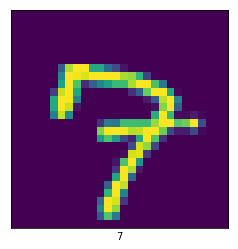

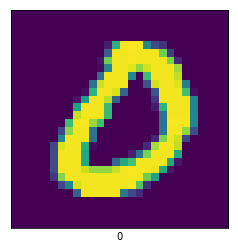

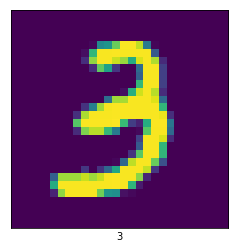

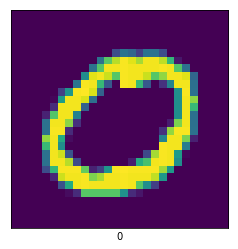

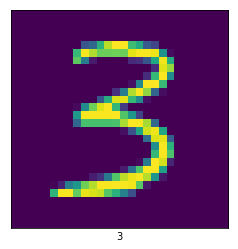

In [19]:
saver = tf.train.Saver()
sol = { 'ImageId': [], 'Label': []}
with tf.Session() as sess:
    saver.restore(sess, './model.ckpt')
    prediction = CNN(x)
    y_pred_cls = tf.argmax(tf.nn.softmax(prediction), 1)
    feed_dict = {x: x_test}
    res = y_pred_cls.eval(feed_dict)
    
    
    for j in range(1, x_test.shape[0]+1):
        sol['ImageId'].append(j)
        sol['Label'].append(res[j-1])
        #print(res)

    for i in range(10):
        j = randrange(0, x_test.shape[0])
        plt.imshow(x_test[j][:, :, 0])
        plt.xticks([], [])
        plt.yticks([], [])
        plt.xlabel(y_pred_cls[j].eval(feed_dict={x: x_test}))
        plt.show()

In [20]:
solv = pd.DataFrame(sol)
solv.shape

(28000, 2)

In [21]:
solv.to_csv('./Results.csv', index=False)